In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX #the big daddy

%matplotlib inline
plt.style.use('ggplot')

In [2]:
ls data/

sample_submission.csv  test.csv               train.csv


In [231]:
df = pd.read_csv('data/train.csv')

In [232]:
df.shape

(913000, 4)

In [233]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [235]:
#check the na values
df.isnull().sum()

#No missing value. great.

date     0
store    0
item     0
sales    0
dtype: int64

In [236]:
#Get the lowest and highest dates in the dataset.
df['date'].min() , df['date'].max()

#there is data for 5 years. great.

('2013-01-01', '2017-12-31')

In [237]:
#set datatime to index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [238]:
df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [242]:
df['year']= df.index.year
df['month']= df.index.month
df['year_and_month']= df.index.to_period('M')
df['day']= df.index.to_period('D')

In [243]:
df.head(5)

,store,item,sales,year,month,year_and_month,day
date,,,,,,,
2013-01-01,1,1,13,2013,1,2013-01,2013-01-01
2013-01-02,1,1,11,2013,1,2013-01,2013-01-02
2013-01-03,1,1,14,2013,1,2013-01,2013-01-03
2013-01-04,1,1,13,2013,1,2013-01,2013-01-04
2013-01-05,1,1,10,2013,1,2013-01,2013-01-05


In [ ]:
df[]

In [265]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series.values)
    ax.set_title("Sales Trend For {}".format(name))
    
    

In [266]:
monthly = df.groupby(pd.Grouper(freq='M'))['sales'].sum()
monthly.columns =['sales']
monthly

date
2013-01-31     454904
2013-02-28     459417
2013-03-31     617382
2013-04-30     682274
2013-05-31     763242
2013-06-30     795597
2013-07-31     855922
2013-08-31     766761
2013-09-30     689907
2013-10-31     656587
2013-11-30     692643
2013-12-31     506607
2014-01-31     525987
2014-02-28     529117
2014-03-31     704301
2014-04-30     788914
2014-05-31     882877
2014-06-30     906842
2014-07-31     989010
2014-08-31     885596
2014-09-30     785124
2014-10-31     758883
2014-11-30     800783
2014-12-31     578048
2015-01-31     552513
2015-02-28     551317
2015-03-31     730951
2015-04-30     824467
2015-05-31     926902
2015-06-30     937184
2015-07-31    1037350
2015-08-31     920401
2015-09-30     823332
2015-10-31     797253
2015-11-30     827645
2015-12-31     607572
2016-01-31     602439
2016-02-29     614957
2016-03-31     790881
2016-04-30     901950
2016-05-31     988730
2016-06-30    1022664
2016-07-31    1138718
2016-08-31     981494
2016-09-30     896831
2016-

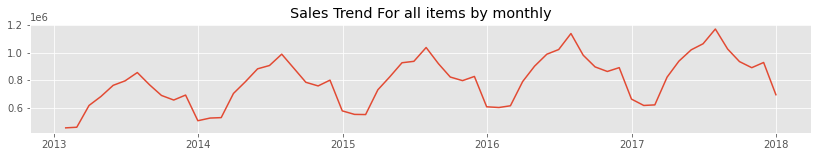

In [267]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_trend_data(ax, 'all items by monthly', monthly)
plt.savefig('images/all_items_by_monthly.png')

In [36]:
daily = df['sales'].resample('d').sum()
type(daily),daily.head()

(pandas.core.series.Series,
 date
 2013-01-01    13696
 2013-01-02    13678
 2013-01-03    14488
 2013-01-04    15677
 2013-01-05    16237
 Freq: D, Name: sales, dtype: int64)

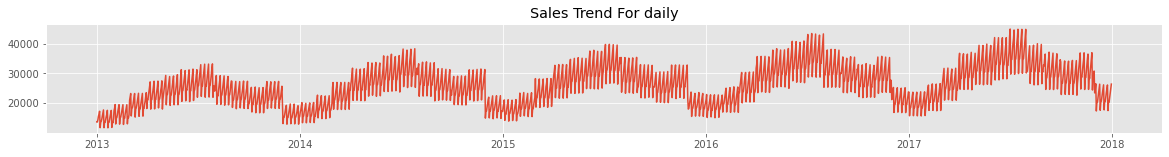

In [35]:
daily.columns =['sales']
fig, ax = plt.subplots(1, figsize=(20, 2))
plot_trend_data(ax, 'daily', daily)

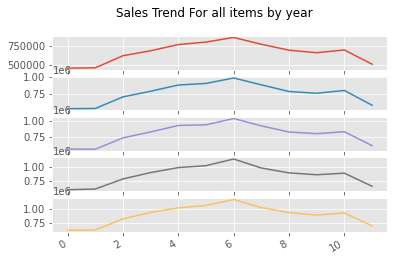

<Figure size 432x288 with 0 Axes>

In [18]:
groups = monthly.groupby(pd.Grouper(freq='Y'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.plot(subplots=True, legend=False,title ='Sales Trend For all items by year')
plt.show()
plt.savefig('images/all_items_by_monthly_and_by_year.png')

In [ ]:
years

#### Univariate Analysis - Store

In [106]:
df['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [107]:
#cuont numbers of stores
store_nums = len(df['store'].unique())
store_nums

10

In [218]:
df.groupby('store')['sales'].sum().sort_values(ascending=False)

store
2     6120128
8     5856169
3     5435144
10    5360158
9     5025976
4     5012639
1     4315603
5     3631016
6     3627670
7     3320009
Name: sales, dtype: int64

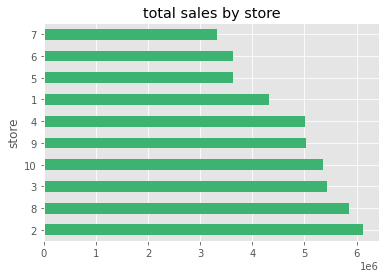

In [217]:
df.groupby('store').sum()['sales'].sort_values(ascending=False).plot(kind='barh', color ='mediumseagreen',title = 'total sales by store')

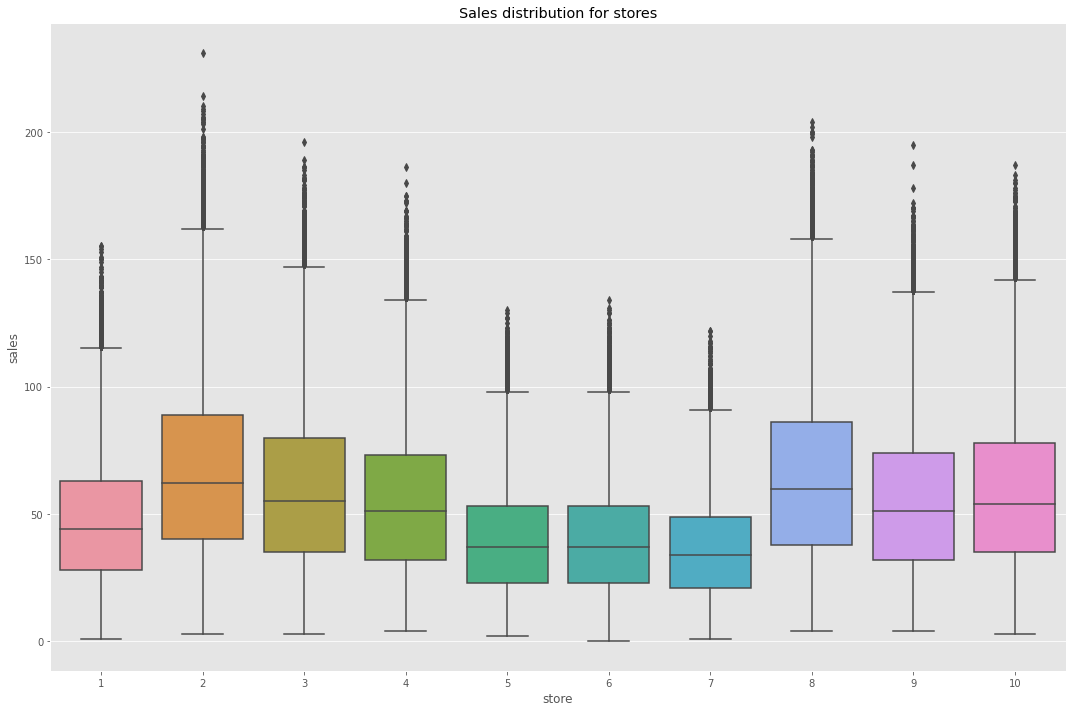

In [203]:
fig, ax = plt.subplots(figsize = (15,10))
ax = sb.boxplot( df['store'],df['sales'])
ax.set_title('Sales distribution for stores')

plt.tight_layout()
plt.savefig('images/Sales_distribution_for_stores.png')

In [258]:
stores = df.groupby(['store','year_and_month'])['sales'].sum()
stores = stores.reset_index()

In [259]:
x = stores.year_and_month.unique()
x

<PeriodArray>
['2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07',
 '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02',
 '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09',
 '2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03', '2015-04',
 '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11',
 '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
 '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01',
 '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
 '2017-09', '2017-10', '2017-11', '2017-12']
Length: 60, dtype: period[M]

In [260]:
stores.sales.min(),stores.sales.max()

(31508, 150105)

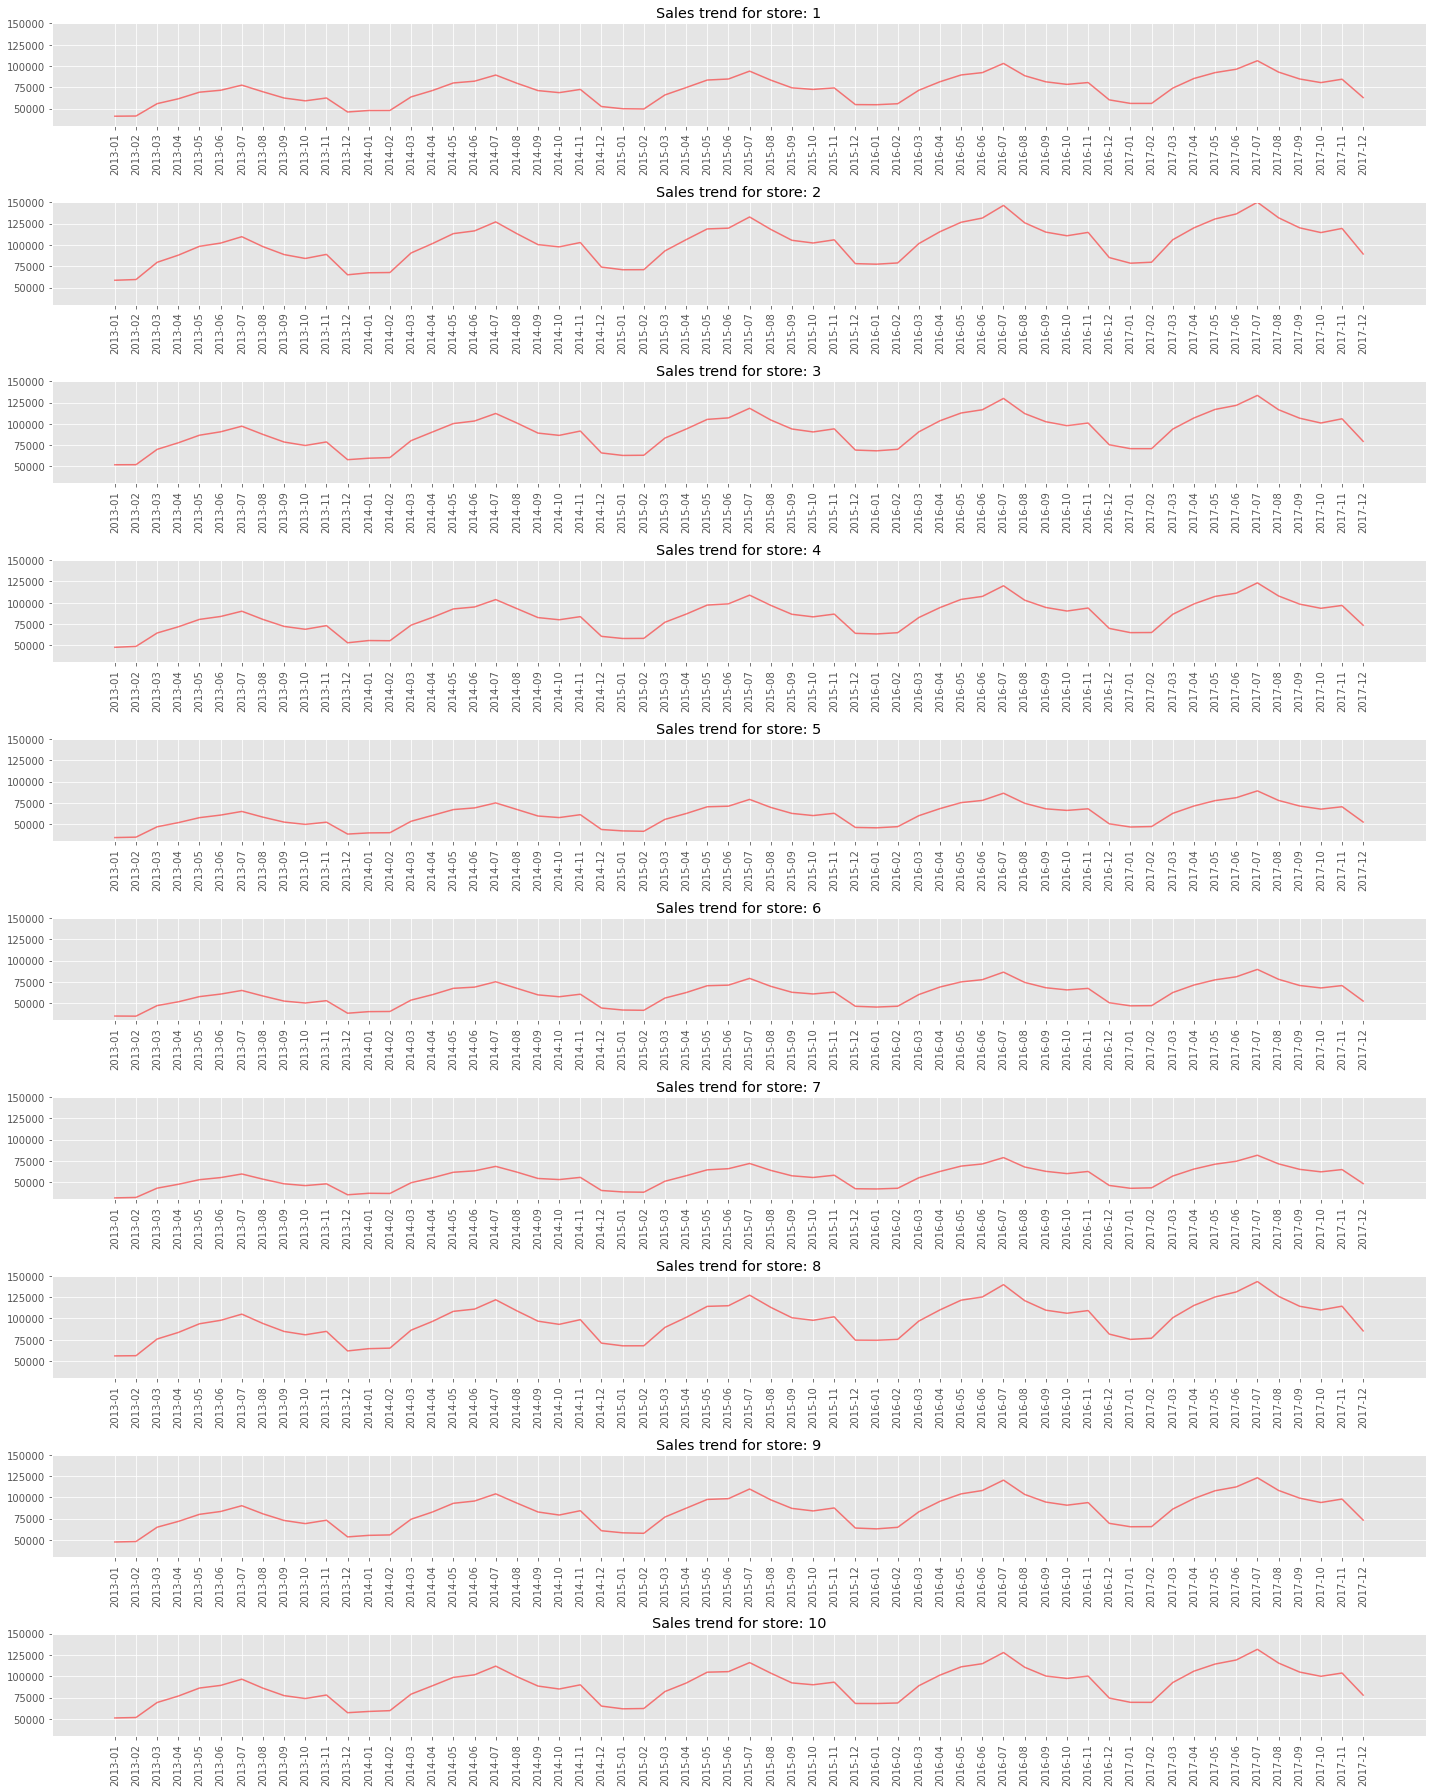

In [214]:
fig,axs = plt.subplots(10,1,figsize=(20,25))

for i, ax in enumerate(axs.flatten()):
    store = stores[stores['store']==(i+1)]
    ax.plot(np.arange(len(x)),store.sales, c="r", alpha=0.5)
    ax.set_title(f"Sales trend for store: {i+1}")
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(x, rotation='vertical')
    ax.set_ylim([30000,150000])

plt.tight_layout()
plt.savefig('images/Sales_trend_for_stores.png')

####  There are seasonal patterns in the data
Sales show very strong oscillations aligned with the season. Sales volume increases quickly as the summer begins, and then falls off as summer goes on.

#### Univariate Analysis - Item

In [72]:
item_nums = len(df['item'].unique())
item_nums

50

Text(0.5, 1.0, 'Sales distribution for items')

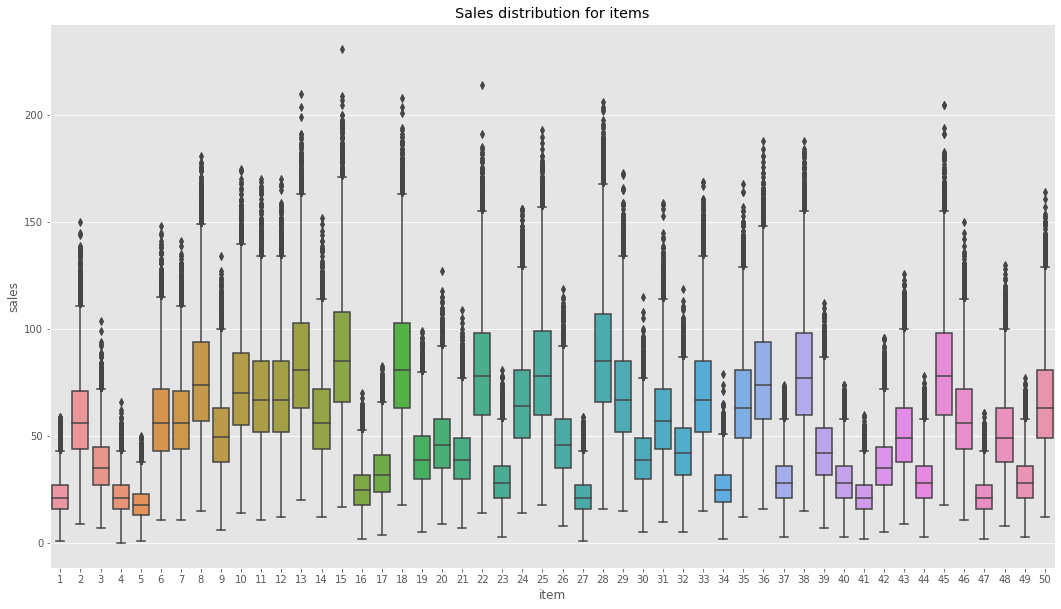

In [199]:
fig, ax = plt.subplots(figsize = (18,10))
ax = sb.boxplot( df['item'],df['sales'])
ax.set_title('Sales distribution for items')

In [206]:
items = df.groupby(['item','year_and_month'])['sales'].sum()
items =items.reset_index()
items

,item,year_and_month,sales
0,1,2013-01,3794
1,1,2013-02,3863
2,1,2013-03,5190
3,1,2013-04,5783
4,1,2013-05,6298
...,...,...,...
2995,50,2017-08,25879
2996,50,2017-09,23308
2997,50,2017-10,22354
2998,50,2017-11,23293


In [211]:
items.sales.min(),items.sales.max(),

(3103, 39524)

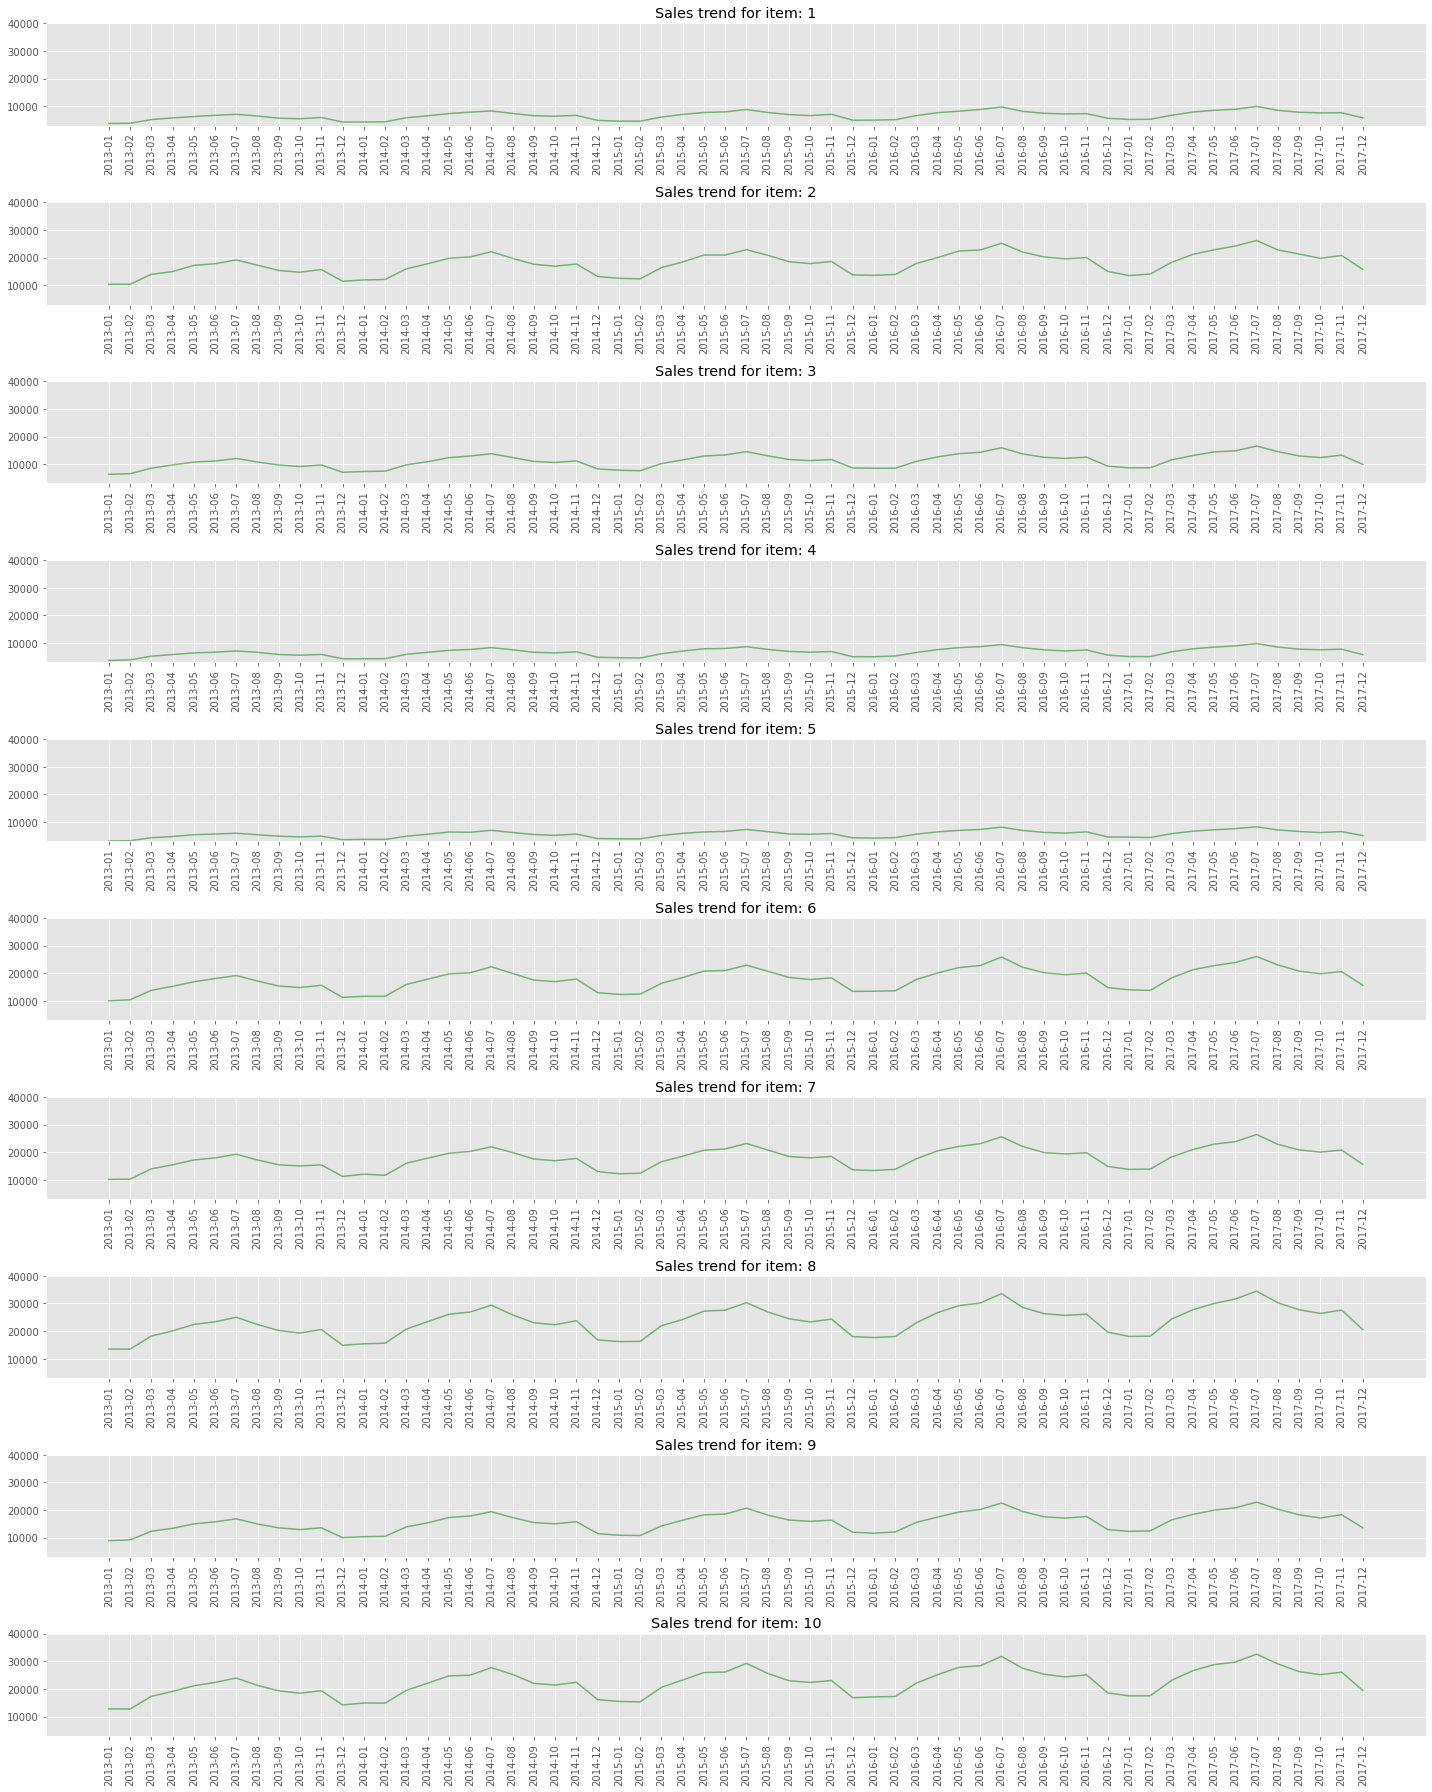

In [212]:
# First 10 items sales trend
fig,axs = plt.subplots(10,1,figsize=(20,25))

for i, ax in enumerate(axs.flatten()):
    item = items[items['item']==(i+1)]
    ax.plot(np.arange(len(x)),item.sales, c="g", alpha=0.5)
    ax.set_title(f"Sales trend for item: {i+1}")
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(x, rotation='vertical')
    ax.set_ylim([3000,40000])

plt.tight_layout()
plt.savefig('images/Sales_trend_for_first_10_items.png')

In [282]:
sales_data = df.iloc[:,:3]
sales_data.shape

(913000, 3)

In [283]:
sales_data

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


In [286]:
sales_data.to_csv('data/sales_data.csv',index =True)

In [278]:
X_train = df.loc['2013-01-01':'2017-09-30']
X_train.sales.sum()

45189345

In [ ]:
X_test = df.loc['2017-10-01':'2017-12-31']

In [ ]:
test

In [ ]:
df.sales.sum() ==(train.sales.sum()+test.sales.sum())